In [0]:
import math
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches

import numpy as np

迷路の形状、報酬を決める

In [0]:
world_width = 10
world_height = 4

reward_goal = 100
reward_cliff = -10
reward_move = -1

cliffs = []
for i in range(1, world_width-1):
    cliffs.append((i, 0))

walls = []
walls.append((3, 1))
walls.append((6, 3))

goals = []
goals.append((world_width-1, 0))

In [0]:
# 割引率γ
gamma = 0.9

# 1エピソードあたり最大何回行動するか
# (理想的には無限回だが適当なところで打ち切る)
max_iter = 100

# 何回エピソードを経験させるか
n_episodes = 10000

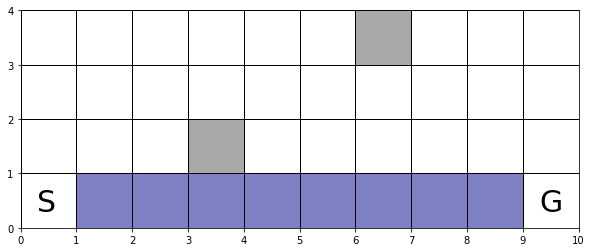

In [0]:
#@title 問題を表示する
def draw_world(history=None, marker_pos=None, values=None):
    global cliffs, walls, reward_goal, reward_cliff, reward_move
    fig = plt.figure(figsize=(world_width, world_height))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlim(0, world_width)
    ax.set_ylim(0, world_height)
    ax.grid(which='major', axis='x', color='k', alpha=1, linestyle='-', linewidth=1)
    ax.grid(which='major', axis='y', color='k', alpha=1, linestyle='-', linewidth=1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    for c in cliffs:
        r = patches.Rectangle(xy=c, width=1, height=1, ec='k', fc='darkblue', alpha=0.5)
        ax.add_patch(r)

    for w in walls:
        r = patches.Rectangle(xy=w, width=1, height=1, ec='k', fc='darkgray')
        ax.add_patch(r)

    if marker_pos is not None:
        c = patches.Circle(xy=(marker_pos[0]+0.5, marker_pos[1]+0.5), radius=0.25, ec='r', fill=False)
        ax.add_patch(c)

    if values is not None:
        vv = np.nan_to_num(values, nan=0, posinf=0, neginf=0)
        vmax = np.max(vv)
        vmin = np.min(vv)
        for x in range(world_width):
            for y in range(world_height):
                col = (np.clip(values[x][y], vmin, vmax) - vmin) / (vmax - vmin)
                col = np.clip(math.atan(10 * col), 0, 1)
                r = patches.Rectangle(xy=(x,y), width=1, height=1, ec='k', fc=(0, col, 0, 0.6))
                ax.add_patch(r)
                ax.text(x + 0.3, y + 0.3, f'{values[x][y]:.1f}', size=10)

    if history is not None:
        X = []
        Y = []
        U = []
        V = []
        x = history[0][0]
        y = history[0][1]
        for i, p in enumerate(history):
            if i == 0:
                continue
            new_x = history[i][0]
            new_y = history[i][1]
            
            if True: #not (new_x == 0 and new_y == 0):
                X.append(x)
                Y.append(y)
                new_x += np.random.normal(0, 0.05)
                new_y += np.random.normal(0, 0.05)
                U.append(new_x - x)
                V.append(new_y - y)
            x = new_x
            y = new_y
        
        X = np.array(X) + 0.5
        Y = np.array(Y) + 0.5
        U = np.array(U)
        V = np.array(V)
        ax.quiver(X, Y, U, V, scale=1, scale_units='xy')

    ax.text(0.3, 0.3, 'S', size=30)
    ax.text(world_width - 1 + 0.3, 0.3, 'G', size=30)
    return ax

draw_world()

In [0]:
# 取りうる行動
# 完全にランダムでもよいが、ここでは右に40%、
# それ以外の方向にはそれぞれ20%の確率で動くようにした

actions = (
    (0, 1), # 上
    (1, 0), # 右
    (0, -1), # 下
    (-1, 0)) #左

action_weights = (0.2, 0.4, 0.2, 0.2)

In [0]:
# 実際に動かしてみる関数
def do_action(s, a):
    reward = 0
    x, y = s
    new_x = x + a[0]
    new_y = y + a[1]
    
    finish = False

    reward += reward_move

    # 迷路の外に飛び出さない
    if new_x < 0 or new_y < 0 or new_x >= world_width or new_y >= world_height:
        new_x = x
        new_y = y

    # 壁にぶつかったらそれ以上進めない
    elif (new_x, new_y) in walls:
        new_x = x
        new_y = y

    # 崖に落ちたら初期位置に戻る
    elif (new_x, new_y) in cliffs:
        new_x = 0
        new_y = 0
        reward += reward_cliff
        finish = True

    # ゴールに着いたとき
    elif (new_x, new_y) in goals:
        reward += reward_goal
        finish = True

    return [new_x, new_y], reward, finish

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

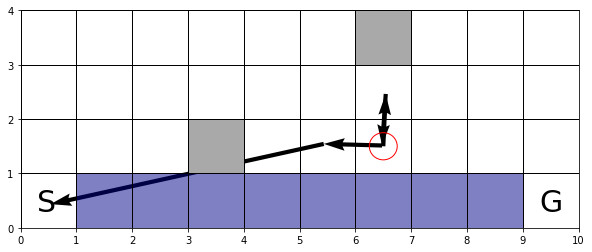

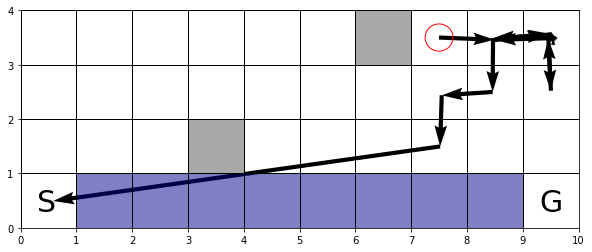

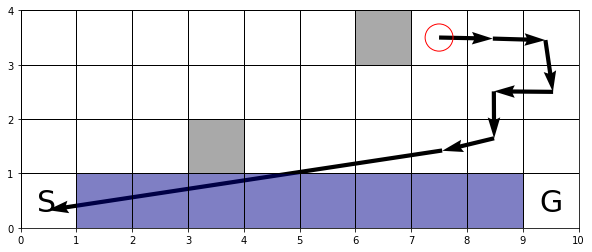

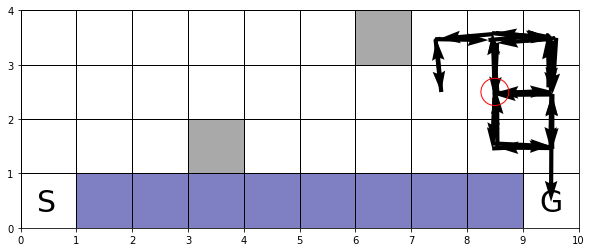

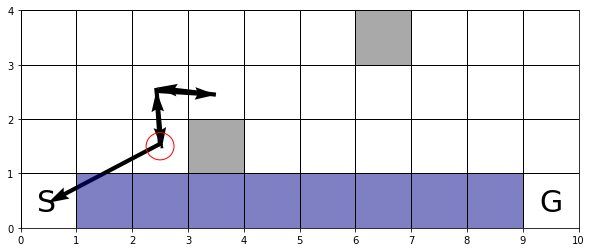

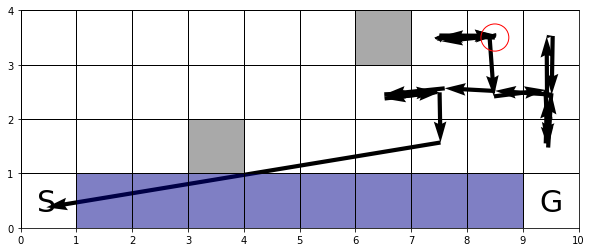

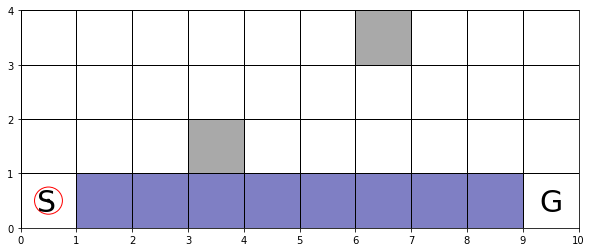

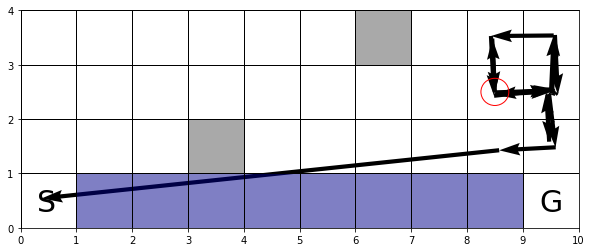

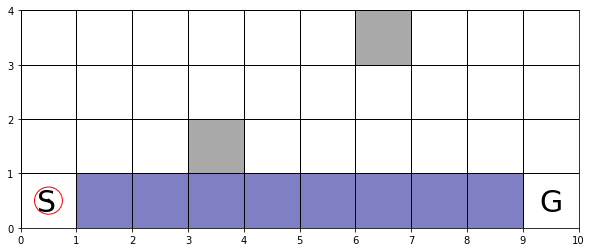

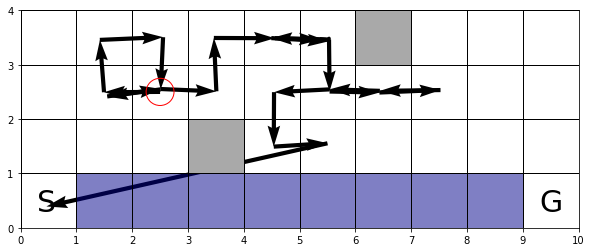

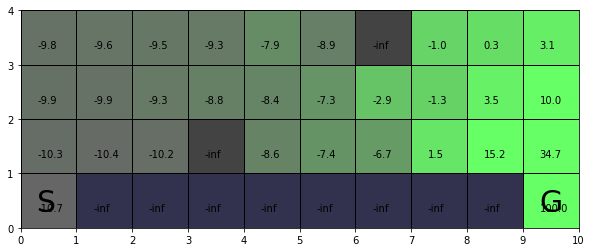

In [0]:
# 空の V(s) を用意
V = [[[] for y in range(world_height)] for x in range(world_width)]

# ランダムな位置からスタート
def set_start_pos():
    while True:
        x = np.random.randint(0, world_width)
        y = np.random.randint(0, world_height)
        if (x, y) in walls or (x, y) in cliffs:
            continue
        else:
            return x, y

for episode in range(n_episodes):
    # エージェントの初期位置をランダムに決める
    init_x, init_y = set_start_pos()
    agent_pos = [init_x, init_y]

    pos_history = [agent_pos] # あとで経路を可視化したいので行動ログをとる
    
    total_reward = 0 # 累積報酬(割引報酬和ともいう)

    # 初期位置がゴールだったときは報酬を与えてすぐにエピソードを終了
    if (agent_pos[0], agent_pos[1]) in goals:
        total_reward = reward_goal

    # それ以外の場合は最大max_iter回行動してみる
    # もしゴールについたらエピソード終了
    else:
        for k in range(max_iter):
            action = random.choices(actions, weights=action_weights, k=1)[0]
            agent_pos, reward, finish = do_action(agent_pos, action)
            
            pos_history.append(agent_pos)

            # 累積報酬(割引報酬和)の計算
            total_reward += gamma ** k * reward

            # ゴールに着いたら終わり
            if finish:
                break
            if agent_pos[0] == world_width-1 and agent_pos[1] == 0:
                break

    # V(s) に対して今回の割引報酬和を記録しておく（あとでまとめて平均を取る）
    V[init_x][init_y].append(total_reward)

    # 最初の10エピソードだけ表示する(全部表示しようとするとメモリが足りなくなる)
    if episode < 10:
        draw_world(pos_history, marker_pos=(init_x, init_y)).plot()

# V(s)を求める
# すべてのsについて、これまでに経験したエピソードでの平均をとる
V = np.array([[np.mean(V[x][y]) for y in range(world_height)] for x in range(world_width)])
V = np.nan_to_num(V, nan=-float('inf'))

# V(s)を可視化
draw_world(values=V).plot()

[]

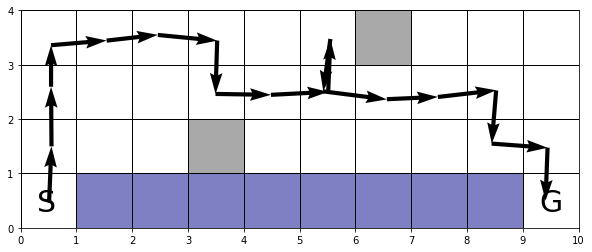

In [0]:

# 求めたV(s)に基づいてε-greedyで動く
# 基本的には より V(s) が高い状態 s になるような行動を取り続ける
# ただしε-greedyで動いているので確率εでランダムに動く

eps = 0.2 # ε-greedy での ε (探索する確率)

def calc_route(V):
    x,y = 0, 0
    history = [(x, y)]

    for i in range(max_iter):
        candidates = []
        for a in actions:
            xx, yy = x + a[0], y + a[1]
            
            if xx < 0 or yy < 0 or xx >= world_width or yy >= world_height:
                v = -float('inf')
            else:
                v = V[xx][yy]
            candidates.append(v)

        if np.random.rand() < eps:
            # Explore
            action = random.choice(actions)
        else:
            # Exploit
            action = actions[np.array(candidates).argmax()]

        (x, y), _, finish = do_action((x, y), action)
        history.append((x, y))

        if (x, y) in goals:
            break
        
    return history

route = calc_route(V)
draw_world(history=route).plot()